<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima statsmodels scikit-learn

In [3]:
#!pip install --upgrade scikit-learn pmdarima

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Load Data

In [5]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df

Ticker,y
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-03-13,81066.703125
2025-03-14,83969.101562
2025-03-15,84343.109375


<Axes: xlabel='Date'>

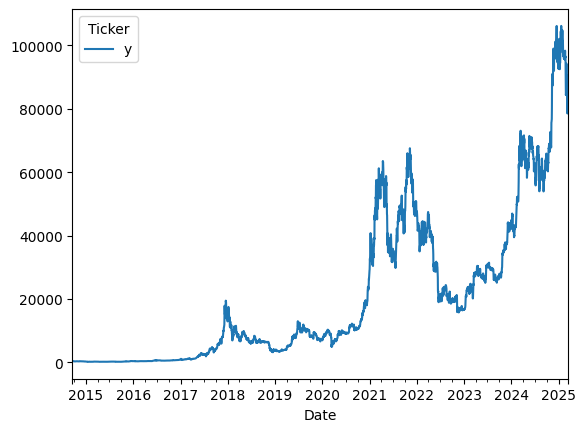

In [7]:
df.plot()

## Train / Test

In [8]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
print(train.shape)
print(test.shape)

(2684, 1)
(1151, 1)


In [9]:
train

Ticker,y
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-01-17,42250.550781
2022-01-18,42375.632812
2022-01-19,41744.328125


<Axes: xlabel='Date'>

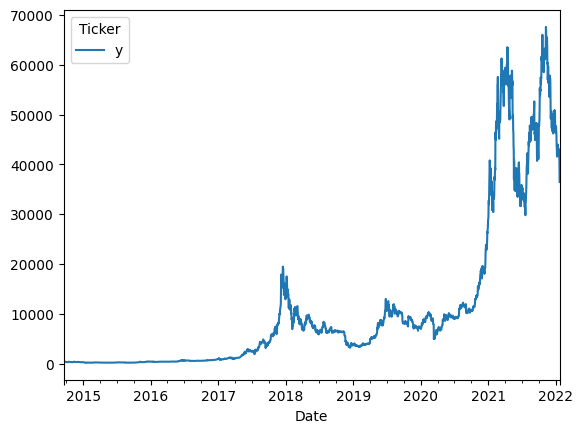

In [10]:
train.plot()

<Axes: xlabel='Date'>

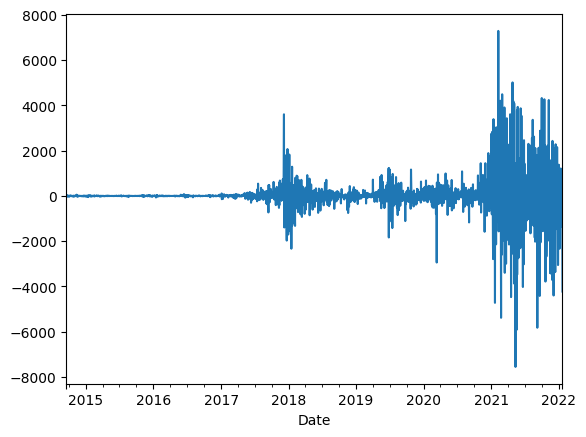

In [11]:
train['y'].diff(1).dropna().plot()

# Normalization

In [12]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [13]:
train_log

Ticker,y
Date,
2014-09-17,6.125414
2014-09-18,6.050771
2014-09-19,5.978369
2014-09-20,6.013480
2014-09-21,5.988513
...,...
2022-01-17,10.651373
2022-01-18,10.654329
2022-01-19,10.639319


<Axes: xlabel='Date'>

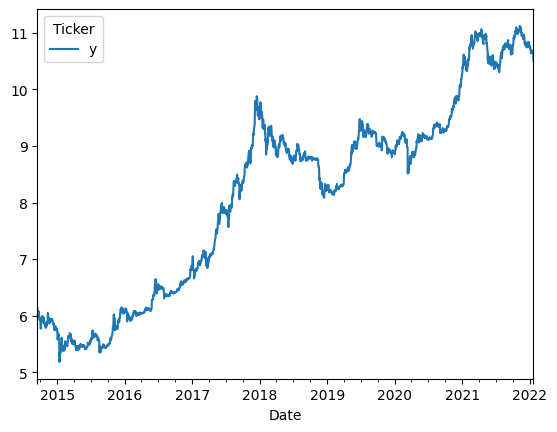

In [14]:
train_log.plot()

# Differentiation

In [15]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## 1ª diff

In [16]:
diff1 = train_log['y'].diff(1).dropna()

<Axes: xlabel='Date'>

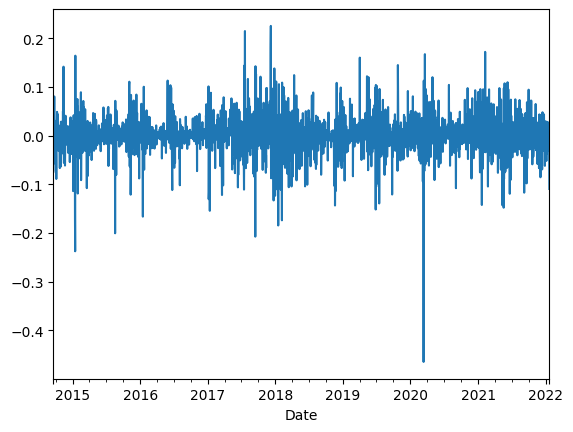

In [17]:
diff1.plot()

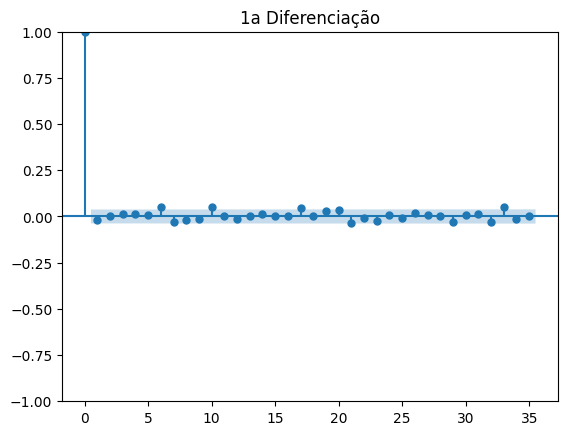

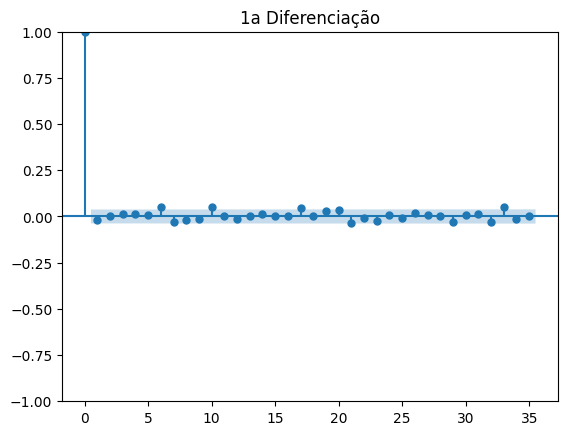

In [18]:
plot_acf(diff1, title='1a Diferenciação')

In [19]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.549768e+01
p-value                 2.438495e-28
# lags used             9.000000e+00
# observations          2.673000e+03
critical value (1%)    -3.432799e+00
critical value (5%)    -2.862622e+00
critical value (10%)   -2.567346e+00
Reject the null hypothesis
Data has no unit root and is stationary


## 2ª diff

In [20]:
diff2 = diff1.diff(1).dropna()


<Axes: xlabel='Date'>

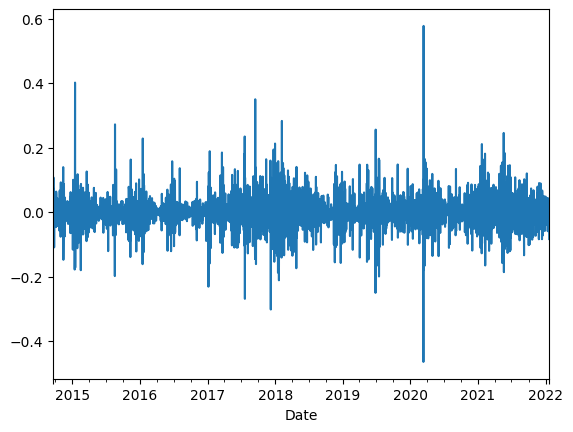

In [21]:
diff2.plot()

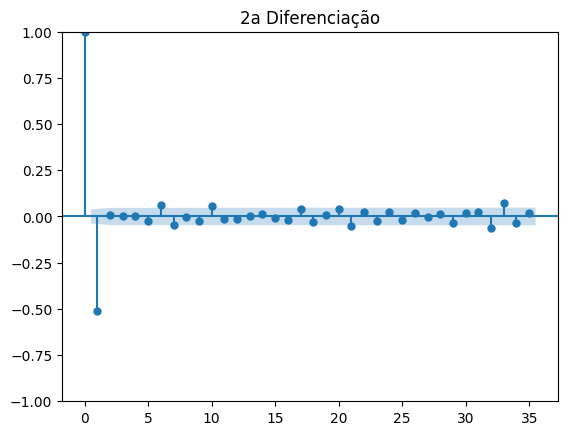

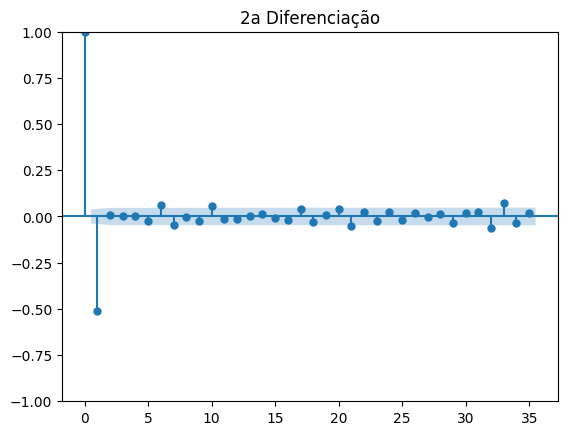

In [22]:
plot_acf(diff2, title='2a Diferenciação')

In [23]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.687147e+01
p-value                 1.080251e-29
# lags used             2.600000e+01
# observations          2.655000e+03
critical value (1%)    -3.432815e+00
critical value (5%)    -2.862629e+00
critical value (10%)   -2.567350e+00
Reject the null hypothesis
Data has no unit root and is stationary


## Análise
A análise dos gráficos sugere os seguintes hiperparâmetros:

In [24]:
p = 1
d = 1
q = 0

# Modelo AR

## lag 1

In [25]:
mod1 = AutoReg(train_log['y'], p, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2684
Model:                     AutoReg(1)   Log Likelihood                4881.872
Method:               Conditional MLE   S.D. of innovations              0.039
Date:                Tue, 25 Mar 2025   AIC                          -9757.743
Time:                        21:28:49   BIC                          -9740.059
Sample:                    09-18-2014   HQIC                         -9751.346
                         - 01-21-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.004      0.816      0.414      -0.004       0.010
y.L1           0.9998      0.000   2285.920      0.000       0.999       1.001
                                    Roots           

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+len(test)-1
predictions1 = np.exp(res1.predict(start=start, end=end, dynamic=False).rename(f'AR({p}) Predictions'))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [27]:
predictions1

,AR(1) Predictions
2022-01-22,36502.685719
2022-01-23,36548.104010
2022-01-24,36593.571325
2022-01-25,36639.087706
2022-01-26,36684.653197
...,...
2025-03-13,133778.476784
2025-03-14,133916.302490
2025-03-15,134054.247474
2025-03-16,134192.311815


<Axes: xlabel='Date'>

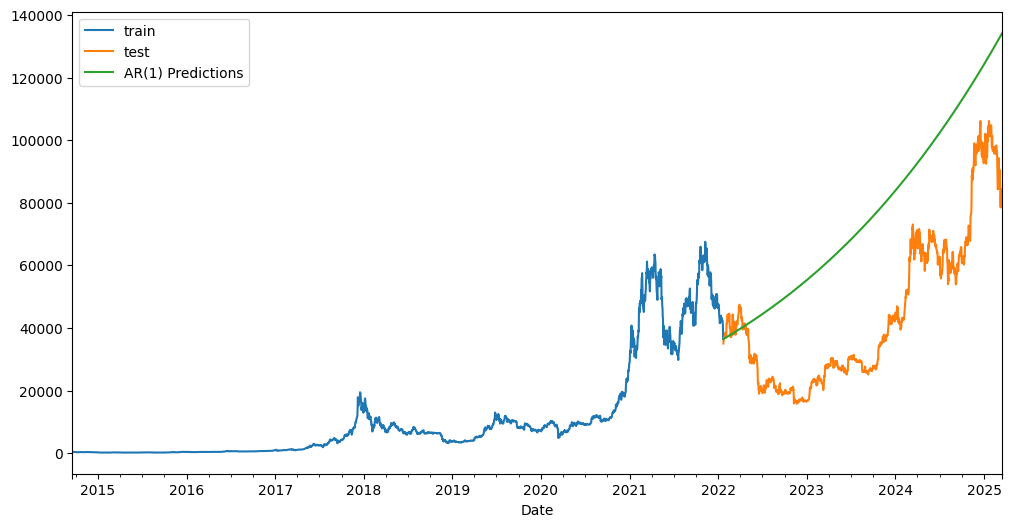

In [28]:
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
predictions1.plot(legend=True,figsize=(12,6))

# Modelo Arima

In [29]:
model = ARIMA(train_log, order=(p,d,q))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2684
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4879.962
Date:                Tue, 25 Mar 2025   AIC                          -9755.924
Time:                        21:28:51   BIC                          -9744.134
Sample:                    09-17-2014   HQIC                         -9751.659
                         - 01-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0190      0.012     -1.557      0.119      -0.043       0.005
sigma2         0.0015   1.65e-05     93.260      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.01   Jarque-

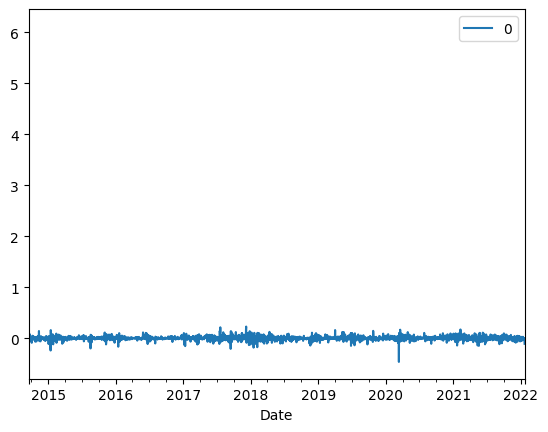

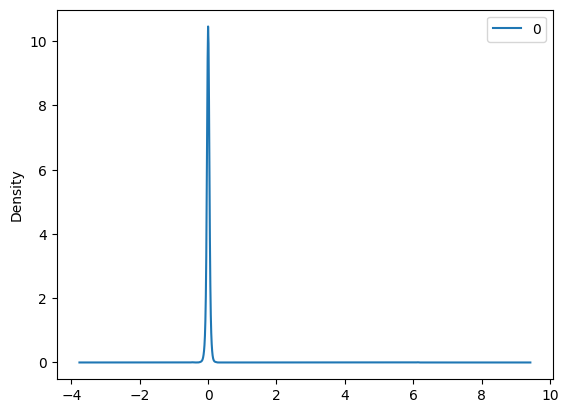

In [30]:

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

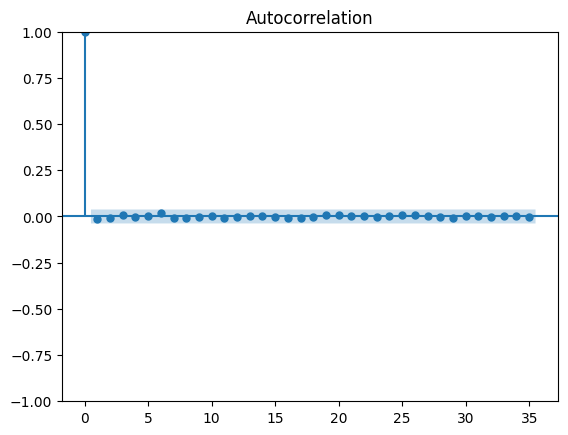

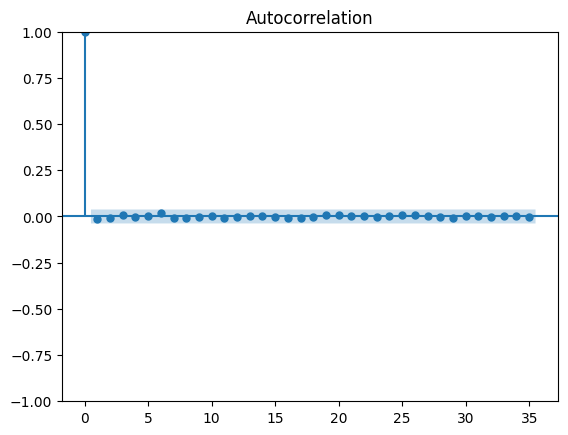

In [31]:
plot_acf(residuals)

In [32]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.698452e+01
p-value                 8.961810e-30
# lags used             9.000000e+00
# observations          2.674000e+03
critical value (1%)    -3.432798e+00
critical value (5%)    -2.862621e+00
critical value (10%)   -2.567346e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [33]:
history = train_log['y'].tolist()

predictions = np.array([])
#walk-foward validation
#test_values = test['y'].tolist()
for t in range(len(test)):
  model = ARIMA(history, order=(p,d,q))
  # fit model
  model_fit = model.fit()
  yhat = np.exp(model_fit.forecast()[0])
  predictions = np.append(predictions, yhat)
  obs = test['y'].iloc[t]
  history.append(np.log(obs))
  print(f'predicted={yhat}, expected={obs}')



predicted=36533.14602816229, expected=35030.25
predicted=35055.21801779323, expected=36276.8046875
predicted=36253.75829723844, expected=36654.328125
predicted=36647.467186361355, expected=36954.00390625
predicted=36948.5699024385, expected=36852.12109375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=36853.95919318304, expected=37138.234375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=37133.04438934459, expected=37784.33203125
predicted=37772.578483073026, expected=38138.1796875
predicted=38131.78184843008, expected=37917.6015625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=37921.563081392356, expected=38483.125
predicted=38472.85342944124, expected=38743.2734375
predicted=38738.573559189215, expected=36952.984375
predicted=36984.61248864114, expected=37154.6015625
predicted=37150.93531474846, expected=41500.875
predicted=41418.362015823914, expected=41441.1640625
predicted=41442.236641724725, expected=42412.43359375
predicted=42394.76725205683, expected=43840.28515625
predicted=43814.45886262551, expected=44118.4453125
predicted=44113.49499108533, expected=44338.796875
predicted=44334.87965032838, expected=43565.11328125
predicted=43578.73140742916, expected=42407.9375
predicted=42428.080607143136, expected=42244.46875
predicted=42247.342184149034, expected=42197.515625
predicted=42198.34202589279, expected=42586.91796875
predicted=42580.02857932334, expected=44575.203125
predicted=44539.59924955282, expected=43961.859375
predicted=43972.61423882277, expected=40538.01171875
predicted=40595.190834789726, expected=40030.9765625
predicted=40039.59

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=40954.84171796645, expected=41801.15625
predicted=41785.66419538875, expected=42190.65234375
predicted=42183.60898998398, expected=41247.82421875
predicted=41264.65457375263, expected=41077.99609375
predicted=41081.05124976127, expected=42358.80859375
predicted=42335.3317068517, expected=42892.95703125
predicted=42883.30409255511, expected=43960.93359375
predicted=43941.59888680053, expected=44348.73046875
predicted=44341.78485306068, expected=44500.828125
predicted=44498.112276553344, expected=46820.4921875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=46778.19979596945, expected=47128.00390625
predicted=47122.54496794844, expected=47465.73046875
predicted=47459.737220755735, expected=47062.6640625
predicted=47069.76768274334, expected=45538.67578125
predicted=45565.11333399193, expected=46281.64453125
predicted=46268.34964957678, expected=45868.94921875
predicted=45876.25718474142, expected=46453.56640625
predicted=46443.087984719925, expected=46622.67578125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=46619.66009537233, expected=45555.9921875
predicted=45574.786121683246, expected=43206.73828125
predicted=43246.85519563226, expected=43503.84765625
predicted=43498.600111455664, expected=42287.6640625
predicted=42308.83025864545, expected=42782.13671875
predicted=42773.3230156815, expected=42207.671875
predicted=42217.80659327373, expected=39521.90234375
predicted=39567.5279742553, expected=40127.18359375
predicted=40116.34917214418, expected=41166.73046875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=41148.125702179204, expected=39935.515625
predicted=39957.17250478422, expected=40553.46484375
predicted=40542.28196032915, expected=40424.484375
predicted=40426.79873200674, expected=39716.953125
predicted=39729.54928397604, expected=40826.21484375
predicted=40805.896204016615, expected=41502.75
predicted=41490.49999448554, expected=41374.37890625
predicted=41376.68255096047, expected=40527.36328125
predicted=40542.41946693525, expected=39740.3203125
predicted=39754.24178418497, expected=39486.73046875
predicted=39491.23740298445, expected=39469.29296875
predicted=39469.603771639566, expected=40458.30859375
predicted=40440.45900742039, expected=38117.4609375
predicted=38158.774795154386, expected=39241.12109375
predicted=39219.95712575059, expected=39773.828125
predicted=39763.922259178464, expected=38609.82421875
predicted=38631.12215456291, expected=37714.875
predicted=37731.151827514695, expected=38469.09375
predicted=38455.00053008874, expected=38529.328125
predicted=385

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=39660.95023923291, expected=36575.140625
predicted=36634.241286181335, expected=36040.921875
predicted=36051.20547559687, expected=35501.953125
predicted=35512.29794099716, expected=34059.265625
predicted=34086.388829083015, expected=30296.953125
predicted=30360.995614808035, expected=31022.90625
predicted=31009.22350213865, expected=28936.35546875
predicted=28974.69012683294, expected=29047.751953125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=29045.6252462483, expected=29283.103515625
predicted=29278.60275476279, expected=30101.265625
predicted=30085.51301292098, expected=31305.11328125
predicted=31282.116831490115, expected=29862.91796875
predicted=29889.923648041615, expected=30425.857421875
predicted=30414.85812760174, expected=28720.271484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=28752.783229479457, expected=30314.333984375
predicted=30281.07200735762, expected=29200.740234375
predicted=29223.461017951842, expected=29432.2265625
predicted=29427.382832313477, expected=30323.72265625
predicted=30304.91770781593, expected=29098.91015625
predicted=29124.200949241284, expected=29655.5859375
predicted=29643.64940703322, expected=29562.361328125
predicted=29564.339954472354, expected=29267.224609375
predicted=29273.465407514745, expected=28627.57421875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=28640.987055677553, expected=28814.900390625
predicted=28810.91100866916, expected=29445.95703125
predicted=29432.43918375029, expected=31726.390625
predicted=31677.165519273713, expected=31792.310546875
predicted=31790.94108037819, expected=29799.080078125
predicted=29839.2093530931, expected=30467.48828125
predicted=30453.232191888517, expected=29704.390625
predicted=29720.388577358393, expected=29832.9140625
predicted=29830.1772679103, expected=29906.662109375
predicted=29905.093317374165, expected=31370.671875
predicted=31338.87466721088, expected=31155.478515625
predicted=31160.043353593406, expected=30214.35546875
predicted=30234.041753441525, expected=30111.998046875
predicted=30114.165060680403, expected=29083.8046875
predicted=29105.212386561845, expected=28360.810546875
predicted=28375.78551011347, expected=26762.6484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=26794.687263530723, expected=22487.388671875
predicted=22559.009921815577, expected=22206.79296875
predicted=22211.711868276638, expected=22572.83984375
predicted=22566.314031359023, expected=20381.650390625
predicted=20419.290381970088, expected=20471.482421875
predicted=20469.85035953901, expected=19017.642578125
predicted=19043.161334702443, expected=20553.271484375
predicted=20522.183264645908, expected=20599.537109375
predicted=20598.637346299016, expected=20710.59765625
predicted=20708.434775038713, expected=19987.029296875
predicted=20000.87099292676, expected=21085.876953125
predicted=21063.434082314634, expected=21231.65625
predicted=21228.760034351424, expected=21502.337890625
predicted=21496.95049843737, expected=21027.294921875
predicted=21036.618865051572, expected=20735.478515625
predicted=20741.20839222175, expected=20280.634765625
predicted=20289.49743976099, expected=20104.0234375
predicted=20107.479319309754, expected=19784.7265625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19790.941960342825, expected=19269.3671875
predicted=19279.298201982863, expected=19242.255859375
predicted=19242.78443590847, expected=19297.076171875
predicted=19296.00508614346, expected=20231.26171875
predicted=20212.63874022018, expected=20190.115234375
predicted=20190.916467114956, expected=20548.24609375
predicted=20541.20206459408, expected=21637.587890625
predicted=21616.03647555672, expected=21731.1171875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=21729.31495070856, expected=21592.20703125
predicted=21594.87054072651, expected=20860.44921875
predicted=20874.25124555577, expected=19970.556640625
predicted=19986.962121981047, expected=19323.9140625
predicted=19335.68437604729, expected=20212.07421875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20194.976441571805, expected=20569.919921875
predicted=20563.19065288982, expected=20836.328125
predicted=20831.34396560449, expected=21190.31640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=21183.698732743487, expected=20779.34375
predicted=20786.920718685582, expected=22485.689453125
predicted=22452.058162476966, expected=23389.43359375
predicted=23372.6371362637, expected=23231.732421875
predicted=23234.60639472854, expected=23164.62890625
predicted=23165.85382934972, expected=22714.978515625
predicted=22723.113596022904, expected=22465.478515625
predicted=22469.998888366015, expected=22609.1640625
predicted=22606.536202376297, expected=21361.701171875
predicted=21383.91666595463, expected=21239.75390625
predicted=21241.970362975248, expected=22930.548828125
predicted=22898.3834257268, expected=23843.88671875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=23827.4811510197, expected=23804.6328125
predicted=23805.32431951023, expected=23656.20703125
predicted=23658.8154766057, expected=23336.896484375
predicted=23342.48168129746, expected=23314.19921875
predicted=23314.59861233325, expected=22978.1171875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=22983.990724774085, expected=22846.5078125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=22848.815240394822, expected=22630.95703125
predicted=22634.726535266193, expected=23289.314453125
predicted=23277.542801889984, expected=22961.279296875
predicted=22967.051656164807, expected=23175.890625
predicted=23172.06403366605, expected=23809.486328125
predicted=23798.12775948208, expected=23164.318359375
predicted=23175.684450970322, expected=23947.642578125
predicted=23933.262359514472, expected=23957.529296875
predicted=23957.35076788291, expected=24402.818359375
predicted=24394.70707189513, expected=24424.068359375
predicted=24423.684695717857, expected=24319.333984375
predicted=24321.220233655156, expected=24136.97265625
predicted=24140.2503987194, expected=23883.291015625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=23887.839239973855, expected=23335.998046875
predicted=23345.71929041894, expected=23212.73828125
predicted=23214.94333704752, expected=20877.552734375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20917.010606672615, expected=21166.060546875
predicted=21160.805435954608, expected=21534.12109375
predicted=21527.42555665334, expected=21398.908203125
predicted=21401.342828044428, expected=21528.087890625
predicted=21525.746699288757, expected=21395.01953125
predicted=21397.417874387218, expected=21600.904296875
predicted=21597.161959988258, expected=20260.01953125
predicted=20283.703011926707, expected=20041.73828125
predicted=20045.65870640474, expected=19616.814453125
predicted=19624.384280521797, expected=20297.994140625
predicted=20285.410762464846, expected=19796.80859375
predicted=19805.89538302387, expected=20049.763671875
predicted=20045.07411267429, expected=20127.140625
predicted=20125.713239124478, expected=19969.771484375
predicted=19972.658931587823, expected=19832.087890625
predicted=19834.613578768116, expected=19986.712890625
predicted=19983.854057673383, expected=19812.37109375
predicted=19815.571048856225, expected=18837.66796875
predicted=18855.09875677

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19771.251758460243, expected=20127.576171875
predicted=20120.90902588861, expected=19419.505859375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19432.557162453828, expected=19544.12890625
predicted=19541.77788230332, expected=18890.7890625
predicted=18902.90322567947, expected=18547.400390625
predicted=18553.76743803198, expected=19413.55078125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19396.81460061712, expected=19297.638671875
predicted=19299.828624613572, expected=18937.01171875
predicted=18943.773018870415, expected=18802.09765625
predicted=18804.637461909995, expected=19222.671875
predicted=19214.625055419612, expected=19110.546875
predicted=19112.665975522934, expected=19426.720703125
predicted=19420.672833514698, expected=19573.05078125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19570.268135240545, expected=19431.7890625
predicted=19434.45764819321, expected=19312.095703125
predicted=19314.356797432465, expected=19044.107421875
predicted=19049.145360971957, expected=19623.580078125
predicted=19612.394685274707, expected=20336.84375
predicted=20323.214275737853, expected=20160.716796875
predicted=20164.021255463118, expected=19955.443359375
predicted=19959.287610752635, expected=19546.849609375
predicted=19554.442904457752, expected=19416.568359375
predicted=19419.00196583872, expected=19446.42578125
predicted=19445.86573614382, expected=19141.484375
predicted=19147.157383137983, expected=19051.41796875
predicted=19053.101088110434, expected=19157.4453125
predicted=19155.453303476745, expected=19382.904296875
predicted=19378.658991947108, expected=19185.65625
predicted=19189.33576776244, expected=19067.634765625
predicted=19069.839046850386, expected=19268.09375
predicted=19264.31624591557, expected=19550.7578125
predicted=19545.430347224974, expected

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=19349.701874031933, expected=20095.857421875
predicted=20081.44870807807, expected=20770.44140625
predicted=20757.71535152016, expected=20285.8359375
predicted=20294.80919022708, expected=20595.3515625
predicted=20589.486062254666, expected=20818.4765625
predicted=20814.265657839343, expected=20635.603515625
predicted=20639.025538546903, expected=20495.7734375
predicted=20498.390700308464, expected=20485.2734375
predicted=20485.470568067987, expected=20159.50390625
predicted=20165.572965400945, expected=20209.98828125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20209.03876214014, expected=21147.23046875
predicted=21129.254203302593, expected=21282.69140625
predicted=21280.15220716901, expected=20926.486328125
predicted=20933.09596349243, expected=20602.81640625
predicted=20608.806842405087, expected=18541.271484375
predicted=18577.041898526404, expected=15880.7802734375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=15916.709086926247, expected=17586.771484375
predicted=17554.460330363698, expected=17034.29296875
predicted=17044.464521893802, expected=16799.185546875
predicted=16803.528713136446, expected=16353.365234375
predicted=16361.51159025598, expected=16618.19921875
predicted=16613.23202659022, expected=16884.61328125
predicted=16879.63232079611, expected=16669.439453125
predicted=16673.415542396564, expected=16687.517578125
predicted=16687.181187908085, expected=16697.77734375
predicted=16697.586479762802, expected=16711.546875
predicted=16711.290693598472, expected=16291.83203125
predicted=16299.542542967958, expected=15787.2841796875
predicted=15796.43629136417, expected=16189.76953125
predicted=16182.193094805396, expected=16610.70703125
predicted=16602.843397921126, expected=16604.46484375
predicted=16604.579974187818, expected=16521.841796875
predicted=16523.36220905898, expected=16464.28125
predicted=16465.341019798172, expected=16444.626953125
predicted=16444.989204949397,

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=17226.209114193574, expected=17133.15234375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=17135.020380783495, expected=17128.724609375
predicted=17128.80727948659, expected=17104.193359375
predicted=17104.65111564868, expected=17206.4375
predicted=17204.52248729925, expected=17781.318359375
predicted=17770.433722369544, expected=17815.650390625
predicted=17815.010755977604, expected=17364.865234375
predicted=17373.15557420555, expected=16647.484375
predicted=16660.40036684585, expected=16795.091796875
predicted=16792.35551267586, expected=16757.9765625
predicted=16758.66102144156, expected=16439.6796875
predicted=16445.497830260952, expected=16906.3046875
predicted=16897.520307534956, expected=16817.53515625
predicted=16819.18187514209, expected=16830.341796875
predicted=16830.103513652117, expected=16796.953125
predicted=16797.573536138687, expected=16847.755859375
predicted=16846.8094809707, expected=16841.986328125
predicted=16842.093629787054, expected=16919.8046875
predicted=16918.353875540557, expected=16717.173828125
predicted=16720.923271029376, expected=1

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=18852.17527410056, expected=19909.57421875
predicted=19890.826055719113, expected=20976.298828125
predicted=20957.76990801059, expected=20880.798828125
predicted=20882.416232675176, expected=21169.6328125
predicted=21164.692909832815, expected=21161.51953125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=21161.657337017376, expected=20688.78125
predicted=20696.722570253158, expected=21086.79296875
predicted=21079.9312864799, expected=22676.552734375
predicted=22648.923894157935, expected=22777.625
predicted=22775.935197259594, expected=22720.416015625
predicted=22721.369347503478, expected=22934.431640625
predicted=22930.84327100363, expected=22636.46875
predicted=22641.417682159063, expected=23117.859375
predicted=23109.699541634935, expected=23032.77734375
predicted=23034.20343971427, expected=23078.728515625
predicted=23077.95608258208, expected=23031.08984375
predicted=23031.889089783985, expected=23774.56640625
predicted=23761.873327002228, expected=22840.138671875
predicted=22855.791053530986, expected=23139.283203125
predicted=23134.10675893918, expected=23723.76953125
predicted=23713.638802798578, expected=23471.87109375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=23476.175586478057, expected=23449.322265625
predicted=23449.70936949352, expected=23331.84765625
predicted=23333.860238286365, expected=22955.666015625
predicted=22962.068508223965, expected=22760.109375
predicted=22763.444182684583, expected=23264.291015625
predicted=23255.542854644384, expected=22939.3984375
predicted=22944.95827656326, expected=21819.0390625
predicted=21837.703436169486, expected=21651.18359375
predicted=21654.02326413532, expected=21870.875
predicted=21867.121983885994, expected=21788.203125
predicted=21789.606482107214, expected=21808.1015625
predicted=21807.762990612224, expected=22220.8046875
predicted=22213.722390771298, expected=24307.841796875
predicted=24271.57471165289, expected=23623.474609375
predicted=23635.057927872116, expected=24565.6015625
predicted=24548.884724625175, expected=24641.27734375
predicted=24639.960490043803, expected=24327.642578125
predicted=24333.060431427857, expected=24829.1484375
predicted=24820.314085521248, expected=24

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=28162.10100089872, expected=28177.984375
predicted=28177.828583825085, expected=28044.140625
predicted=28046.242770237397, expected=27925.859375
predicted=27927.71706037703, expected=27947.794921875
predicted=27947.449543964474, expected=28333.05078125
predicted=28326.947187409623, expected=29652.98046875
predicted=29631.923780816982, expected=30235.05859375
predicted=30226.007638632484, expected=30139.052734375
predicted=30140.53022243568, expected=30399.06640625
predicted=30395.040127077038, expected=30485.69921875
predicted=30484.361987030024, expected=30318.49609375
predicted=30321.06695660976, expected=30315.35546875
predicted=30315.40388582054, expected=29445.044921875
predicted=29458.27058773302, expected=30397.552734375
predicted=30382.445151818734, expected=28822.6796875
predicted=28847.191450769486, expected=28245.98828125
predicted=28254.973124768327, expected=27276.91015625
predicted=27291.75196863705, expected=27817.5
predicted=27808.916309896427, expected=27591.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=29342.35890251511, expected=29248.48828125
predicted=29249.930408544464, expected=29268.806640625
predicted=29268.486747022274, expected=28091.568359375
predicted=28109.73181551459, expected=28680.537109375
predicted=28671.06255805413, expected=29006.30859375
predicted=29001.10937595033, expected=28847.7109375
predicted=28850.223361353834, expected=29534.384765625
predicted=29523.331368731273, expected=28904.623046875
predicted=28914.60521790973, expected=28454.978515625
predicted=28462.09303363914, expected=27694.2734375
predicted=27706.172367516112, expected=27658.775390625
predicted=27659.337409597112, expected=27621.755859375
predicted=27622.341936550714, expected=27000.7890625
predicted=27010.512706823476, expected=26804.990234375
predicted=26808.07236491264, expected=26784.078125
predicted=26784.40833452424, expected=26930.638671875
predicted=26928.317183251133, expected=27192.693359375
predicted=27188.536872024993, expected=27036.650390625
predicted=27039.108510566937,

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=27227.34386413404, expected=26819.97265625
predicted=26826.32267493852, expected=27249.58984375
predicted=27242.63879981793, expected=27075.12890625
predicted=27077.924508828342, expected=27119.06640625
predicted=27118.3594555988, expected=25760.09765625
predicted=25781.421769621138, expected=27238.783203125
predicted=27213.39668043008, expected=26345.998046875
predicted=26361.012516041665, expected=26508.216796875
predicted=26505.42860529794, expected=26480.375
predicted=26480.85188851893, expected=25851.240234375
predicted=25861.891642503662, expected=25940.16796875
predicted=25938.640497707955, expected=25902.5


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=25903.14549235978, expected=25918.728515625
predicted=25918.45013021875, expected=25124.67578125
predicted=25138.088955518066, expected=25576.39453125
predicted=25568.525278406036, expected=26327.462890625
predicted=26314.39297533761, expected=26510.67578125
predicted=26507.530274369365, expected=26336.212890625
predicted=26339.18999924377, expected=26851.029296875
predicted=26842.11733102038, expected=28327.48828125
predicted=28301.839934313855, expected=30027.296875
predicted=29998.893875962858, expected=29912.28125
predicted=29914.14970685085, expected=30695.46875
predicted=30682.542006324846, expected=30548.6953125
predicted=30551.08524571816, expected=30480.26171875
predicted=30481.377268631455, expected=30271.130859375
predicted=30274.531466385626, expected=30688.1640625
predicted=30681.30547340199, expected=30086.24609375
predicted=30096.01791899048, expected=30445.3515625
predicted=30439.412304530117, expected=30477.251953125
predicted=30476.727249360014, expected=305

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=30173.22979199685, expected=30414.470703125
predicted=30410.444185729866, expected=30620.951171875
predicted=30617.537698965978, expected=30391.646484375
predicted=30395.413212095966, expected=31476.048828125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=31457.79730435604, expected=30334.068359375
predicted=30352.927980554552, expected=30295.806640625
predicted=30296.44917569576, expected=30249.1328125
predicted=30249.916485884725, expected=30145.888671875
predicted=30147.620467697754, expected=29856.5625
predicted=29861.398698179084, expected=29913.923828125
predicted=29912.959332604474, expected=29792.015625
predicted=29794.059598429383, expected=29908.744140625
predicted=29906.778911151207, expected=29771.802734375
predicted=29774.09917246622, expected=30084.5390625
predicted=30079.252518294223, expected=29176.916015625
predicted=29192.012569412273, expected=29227.390625
predicted=29226.537178901624, expected=29354.97265625
predicted=29352.812866664073, expected=29210.689453125
predicted=29213.121503959275, expected=29319.24609375
predicted=29317.408049842703, expected=29356.91796875
predicted=29356.28092150737, expected=29275.30859375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=29276.685947687023, expected=29230.111328125
predicted=29230.87456198931, expected=29675.732421875
predicted=29668.143223047766, expected=29151.958984375
predicted=29160.765533717535, expected=29178.6796875
predicted=29178.22619233382, expected=29074.091796875
predicted=29075.86297427113, expected=29042.126953125
predicted=29042.66890674998, expected=29041.85546875
predicted=29041.860074146814, expected=29180.578125
predicted=29178.219338404695, expected=29765.4921875
predicted=29755.48474877141, expected=29561.494140625
predicted=29564.944572489687, expected=29429.591796875
predicted=29431.82454804542, expected=29397.71484375
predicted=29398.2552989107, expected=29415.96484375
predicted=29415.6551637505, expected=29282.9140625
predicted=29285.166135593547, expected=29408.443359375
predicted=29406.308861055095, expected=29170.34765625
predicted=29174.37336928691, expected=28701.779296875
predicted=28709.657153339773, expected=26664.55078125
predicted=26697.335682291872, expec

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=26088.36394561332, expected=26106.150390625
predicted=26105.88139243397, expected=27727.392578125
predicted=27700.121779519923, expected=27297.265625
predicted=27304.317526671097, expected=25931.47265625
predicted=25953.242438165635, expected=25800.724609375
predicted=25802.848387006172, expected=25868.798828125
predicted=25867.688699463004, expected=25969.56640625
predicted=25967.92233794142, expected=25812.416015625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=25814.968249368456, expected=25779.982421875
predicted=25780.510358283595, expected=25753.236328125
predicted=25753.6717258428, expected=26240.1953125
predicted=26232.188750885052, expected=25905.654296875
predicted=25911.08684013521, expected=25895.677734375
predicted=25895.84072126685, expected=25832.2265625
predicted=25833.262095997314, expected=25162.654296875
predicted=25173.445163834724, expected=25833.34375
predicted=25822.152838873466, expected=26228.32421875
predicted=26221.804560917775, expected=26539.673828125
predicted=26534.555373777504, expected=26608.693359375
predicted=26607.564313493727, expected=26568.28125
predicted=26568.941021610706, expected=26534.1875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=26534.74416748621, expected=26754.28125
predicted=26750.670257632097, expected=27211.1171875
predicted=27203.60400923967, expected=27132.0078125
predicted=27133.296989665214, expected=26567.6328125
predicted=26576.740879647226, expected=26579.568359375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=26579.373685510516, expected=26579.390625
predicted=26579.393523273193, expected=26256.826171875
predicted=26262.054641291474, expected=26298.48046875
predicted=26297.800539425654, expected=26217.25
predicted=26218.572973693525, expected=26352.716796875
predicted=26350.501068807927, expected=27021.546875
predicted=27010.518750392206, expected=26911.720703125
predicted=26913.5080275417, expected=26967.916015625
predicted=26966.998612473508, expected=27983.75
predicted=27966.897259793852, expected=27530.78515625
predicted=27538.161707574774, expected=27429.978515625
predicted=27431.62903453195, expected=27799.39453125
predicted=27793.291270848345, expected=27415.912109375
predicted=27422.178280795157, expected=27946.59765625
predicted=27937.75389710488, expected=27968.83984375
predicted=27968.47261294212, expected=27935.08984375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=27935.646533254177, expected=27583.677734375
predicted=27589.440369407377, expected=27391.01953125
predicted=27394.183887558123, expected=26873.3203125
predicted=26881.75815626036, expected=26756.798828125
predicted=26758.709608466383, expected=26862.375
predicted=26860.636259157396, expected=26861.70703125
predicted=26861.718010637152, expected=27159.65234375
predicted=27154.72833094422, expected=28519.466796875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=28496.73516560297, expected=28415.748046875
predicted=28417.440935027036, expected=28328.341796875
predicted=28329.76861552814, expected=28719.806640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=28713.359833766524, expected=29682.94921875
predicted=29667.032844259295, expected=29918.412109375
predicted=29914.582601221442, expected=29993.896484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=29992.672406689024, expected=33086.234375
predicted=33033.86604999608, expected=33901.52734375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=33888.65559420621, expected=34502.8203125
predicted=34493.41519062681, expected=34156.6484375
predicted=34162.002575462524, expected=33909.80078125
predicted=33913.620109338866, expected=34089.57421875
predicted=34086.77402035959, expected=34538.48046875
predicted=34531.468059531355, expected=34502.36328125
predicted=34502.92365021421, expected=34667.78125
predicted=34665.20719229084, expected=35437.25390625
predicted=35425.19628202843, expected=34938.2421875
predicted=34945.95605722297, expected=34732.32421875
predicted=34735.51655802091, expected=35082.1953125
predicted=35076.72417760232, expected=35049.35546875
predicted=35049.86629860872, expected=35037.37109375
predicted=35037.55756657313, expected=35443.5625
predicted=35437.204963367745, expected=35655.27734375
predicted=35651.97593523594, expected=36693.125
predicted=36676.7980487993, expected=37313.96875
predicted=37304.32479399098, expected=37138.05078125
predicted=37140.75748530584, expected=37054.51953125
predicted

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=39541.69840387475, expected=39845.55078125
predicted=39839.65980825124, expected=40077.07421875
predicted=40073.04908636348, expected=39933.80859375
predicted=39936.288490155624, expected=41816.87109375
predicted=41783.40663056457, expected=42120.0546875
predicted=42114.79186707145, expected=42035.59375
predicted=42037.05347780349, expected=43288.24609375
predicted=43266.24538017792, expected=42952.609375
predicted=42958.4129032115, expected=42582.60546875
predicted=42588.99519806148, expected=43075.7734375
predicted=43067.16167632357, expected=43185.859375
predicted=43183.94621276709, expected=42992.25
predicted=42995.60353222142, expected=42583.58203125
predicted=42590.63931826739, expected=42658.66796875
predicted=42657.36383614197, expected=43084.671875
predicted=43077.244646403546, expected=44318.22265625
predicted=44296.59702377003, expected=45301.56640625
predicted=45284.512801156554, expected=47147.19921875
predicted=47115.25957568563, expected=47771.27734375
predicte

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=51730.504636203696, expected=54522.40234375
predicted=54474.326280411915, expected=57085.37109375
predicted=57042.69091113799, expected=62504.7890625
predicted=62417.557741553195, expected=61198.3828125
predicted=61218.776764108734, expected=62440.6328125
predicted=62420.73304077332, expected=62029.84765625
predicted=62036.35315197388, expected=63167.37109375
predicted=63149.106988284395, expected=68330.4140625
predicted=68246.64942067803, expected=63801.19921875
predicted=63874.41119893448, expected=66106.8046875
predicted=66066.41629071117, expected=66925.484375
predicted=66911.38410494164, expected=68300.09375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=68276.39881990777, expected=68498.8828125
predicted=68495.48809125792, expected=69019.7890625
predicted=69010.87555114596, expected=72123.90625
predicted=72070.05689984349, expected=71481.2890625
predicted=71492.19982208055, expected=73083.5
predicted=73055.8111337629, expected=71396.59375
predicted=71425.27904765247, expected=69403.7734375
predicted=69437.30215599886, expected=65315.1171875
predicted=65381.37388933411, expected=68390.625
predicted=68336.30207936512, expected=67548.59375
predicted=67563.14035990866, expected=61912.7734375
predicted=62005.37547586332, expected=67913.671875
predicted=67795.60073112158, expected=65491.390625
predicted=65537.73037601323, expected=63778.76171875
predicted=63811.33653332997, expected=64062.203125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=64056.723266325935, expected=67234.171875
predicted=67171.66413932636, expected=69958.8125
predicted=69906.47940065019, expected=69987.8359375
predicted=69987.28936500478, expected=69455.34375
predicted=69465.33249121015, expected=70744.953125
predicted=70720.41363193077, expected=69892.828125
predicted=69908.8402476701, expected=69645.3046875
predicted=69649.97312299443, expected=71333.6484375
predicted=71301.34345794759, expected=69702.1484375
predicted=69732.83524307127, expected=65446.97265625
predicted=65524.18814963112, expected=65980.8125
predicted=65970.73100713648, expected=68508.84375
predicted=68460.57356055178, expected=67837.640625
predicted=67850.2100560271, expected=68896.109375
predicted=68876.00666432286, expected=69362.5546875
predicted=69353.74423689421, expected=71631.359375
predicted=71588.07301236498, expected=69139.015625
predicted=69185.58515071202, expected=70587.8828125
predicted=70559.83789117754, expected=70060.609375
predicted=70070.69137187136, e

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=63119.18894051104, expected=63841.12109375
predicted=63826.82131733102, expected=60636.85546875
predicted=60698.26557079694, expected=58254.01171875
predicted=58298.91370535791, expected=59123.43359375
predicted=59106.50028723135, expected=62889.8359375
predicted=62815.520159925865, expected=63891.47265625
predicted=63872.36546603886, expected=64031.1328125
predicted=64028.48750422724, expected=63161.94921875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=63178.29013205076, expected=62334.81640625
predicted=62350.3392656157, expected=61187.94140625
predicted=61209.349658368155, expected=63049.9609375
predicted=63014.15171184763, expected=60792.77734375
predicted=60835.28647913136, expected=60793.7109375
predicted=60793.69304180113, expected=61448.39453125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=61435.779235740185, expected=62901.44921875
predicted=62873.352631716276, expected=61552.7890625
predicted=61578.434058245664, expected=66267.4921875
predicted=66171.95941517493, expected=65231.58203125
predicted=65251.89909722178, expected=67051.875
predicted=67015.24633803913, expected=66940.8046875
predicted=66943.0087227884, expected=66278.3671875
predicted=66291.45675480286, expected=71448.1953125
predicted=71340.89441760984, expected=70136.53125
predicted=70162.8823868727, expected=69122.3359375
predicted=69142.69325533876, expected=67929.5625
predicted=67953.40811124103, expected=68526.1015625
predicted=68514.00380971102, expected=69265.9453125
predicted=69250.9413140121, expected=68518.09375
predicted=68533.11804268685, expected=69394.5546875
predicted=69376.71759529042, expected=68296.21875
predicted=68318.30428613424, expected=67578.09375
predicted=67592.54658750737, expected=68364.9921875
predicted=68348.96291237307, expected=67491.4140625
predicted=67509.023358665

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=69515.01382421405, expected=67332.03125
predicted=67375.26307937941, expected=68241.1875
predicted=68222.67833419387, expected=66756.3984375
predicted=66786.19455664288, expected=66011.09375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=66026.0903896188, expected=66191.0
predicted=66187.35414149724, expected=66639.046875
predicted=66629.95086605864, expected=66490.296875
predicted=66493.30389838651, expected=65140.74609375
predicted=65167.77145308528, expected=64960.296875
predicted=64963.939617344986, expected=64828.65625
predicted=64831.31450407919, expected=64096.19921875
predicted=64110.91889334299, expected=64252.578125
predicted=64249.413346470494, expected=63180.796875
predicted=63202.29246679863, expected=60277.4140625
predicted=60334.318463119314, expected=61804.640625
predicted=61773.27021142126, expected=60811.27734375
predicted=60831.353759231104, expected=61604.80078125
predicted=61588.49879896845, expected=60320.13671875
predicted=60346.16246044385, expected=60887.37890625
predicted=60875.69248385054, expected=62678.29296875
predicted=62641.142942961735, expected=62851.98046875
predicted=62848.42689647222, expected=62029.015625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=62045.72812277558, expected=60173.921875
predicted=60211.12593375766, expected=56977.703125
predicted=57039.97031417558, expected=56662.375
predicted=56668.64480626357, expected=58303.5390625
predicted=58270.30436025387, expected=55849.109375
predicted=55897.69652833616, expected=56705.09765625
predicted=56687.55221448605, expected=58009.2265625
predicted=57982.491861769915, expected=57742.49609375
predicted=57747.89657960089, expected=57344.9140625
predicted=57352.95219759487, expected=57899.46484375
predicted=57888.154541943084, expected=59231.953125
predicted=59204.662646640245, expected=60787.79296875
predicted=60756.07271077043, expected=64870.15234375
predicted=64786.7931088181, expected=65097.1484375
predicted=65092.66464204379, expected=64118.79296875
predicted=64137.9527546819, expected=63974.06640625
predicted=63976.91751607356, expected=66710.15625
predicted=66655.02647645911, expected=67163.6484375
predicted=67154.69587835087, expected=68154.5234375
predicted=6813

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=66213.06264091576, expected=64619.25
predicted=64649.742507997726, expected=65357.5
predicted=65342.97792979551, expected=61415.06640625
predicted=61490.41034489975, expected=60680.09375
predicted=60694.36843269847, expected=58116.9765625
predicted=58165.732141057895, expected=53991.45703125
predicted=54066.14106320365, expected=56034.31640625
predicted=55994.14439600826, expected=55027.4609375
predicted=55046.86361620062, expected=61710.13671875
predicted=61569.785604841505, expected=60880.11328125
predicted=60896.7100888802, expected=60945.8125
predicted=60944.489205551865, expected=58719.484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=58763.508321970156, expected=59354.515625
predicted=59341.610677162826, expected=60609.56640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=60583.99324974329, expected=58737.26953125
predicted=58774.69697654687, expected=57560.09765625
predicted=57583.603278664166, expected=58894.10546875
predicted=58866.77407793747, expected=59478.97265625
predicted=59467.09416330821, expected=58483.96484375
predicted=58503.94298978453, expected=59493.453125
predicted=59472.78539160367, expected=59012.79296875
predicted=59022.52593289617, expected=61175.19140625
predicted=61130.320733315384, expected=60381.9140625
predicted=60398.056050982625, expected=64094.35546875
predicted=64015.48283709908, expected=64178.9921875
predicted=64177.24704803227, expected=64333.54296875
predicted=64330.35466579268, expected=62880.66015625
predicted=62910.279466197375, expected=59504.1328125
predicted=59571.03012276277, expected=59027.625
predicted=59037.23882213035, expected=59388.1796875
predicted=59380.851253453424, expected=59119.4765625
predicted=59124.91118965618, expected=58969.8984375
predicted=58972.92632177467, expected=57325.48828125
p

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=63166.218083641346, expected=65181.01953125
predicted=65139.19960441263, expected=65790.6640625
predicted=65778.3289326542, expected=65887.6484375
predicted=65885.69393919852, expected=65635.3046875
predicted=65640.37716875022, expected=63329.5
predicted=63375.06522436502, expected=60837.0078125
predicted=60885.43216496781, expected=60632.78515625
predicted=60636.81837979009, expected=60759.40234375
predicted=60756.89490068001, expected=62067.4765625
predicted=62041.33963624888, expected=62089.94921875
predicted=62089.50483953036, expected=62818.953125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=62804.45821523521, expected=62236.66015625
predicted=62248.13197719745, expected=62131.96875
predicted=62134.03865278787, expected=60582.1015625
predicted=60612.3786640861, expected=60274.5
predicted=60280.56016959735, expected=62445.08984375
predicted=62401.39158497828, expected=63193.0234375
predicted=63178.205465022125, expected=62851.375
predicted=62858.09074518729, expected=66046.125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=65981.43919855628, expected=67041.109375
predicted=67021.46064161103, expected=67612.71875
predicted=67601.48160482592, expected=67399.8359375
predicted=67403.99823602947, expected=68418.7890625
predicted=68398.67869045332, expected=68362.734375
predicted=68363.83223810847, expected=69001.703125
predicted=68989.12535502765, expected=67367.8515625
predicted=67399.56445693669, expected=67361.40625
predicted=67361.53281044132, expected=66432.1953125
predicted=66450.31798107874, expected=68161.0546875
predicted=68126.55138236682, expected=66642.4140625
predicted=66672.18598424176, expected=67014.6953125
predicted=67007.2869191447, expected=67929.296875
predicted=67911.03922958243, expected=69907.7578125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=69868.12885627759, expected=72720.4921875
predicted=72664.52229003682, expected=72339.5390625
predicted=72346.96929064005, expected=70215.1875
predicted=70256.05785238, expected=69482.46875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=69496.65151342207, expected=69289.2734375
predicted=69293.02594399544, expected=68741.1171875
predicted=68751.73486469303, expected=67811.5078125
predicted=67829.44366021235, expected=69359.5625
predicted=69329.06416486409, expected=75639.078125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=75514.05102425112, expected=75904.859375
predicted=75899.80150611227, expected=76545.4765625
predicted=76533.26006105574, expected=76778.8671875
predicted=76774.42939586319, expected=80474.1875
predicted=80402.50715379824, expected=88701.484375
predicted=88545.97415533743, expected=87955.8125
predicted=87969.29611606547, expected=90584.1640625
predicted=90535.61365524863, expected=87250.4296875
predicted=87310.7341716336, expected=91066.0078125
predicted=90992.97775730657, expected=90558.4765625
predicted=90567.98432576541, expected=89845.8515625
predicted=89859.17989098586, expected=90542.640625
predicted=90529.49977276573, expected=92343.7890625
predicted=92309.6773064053, expected=94339.4921875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=94301.83820979501, expected=98504.7265625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=98426.09408533818, expected=98997.6640625
predicted=98988.55526213576, expected=97777.28125
predicted=97799.65536902087, expected=98013.8203125
predicted=98009.45070304566, expected=93102.296875
predicted=93190.77220851179, expected=91985.3203125
predicted=92005.68651738571, expected=95962.53125
predicted=95887.64218346134, expected=95652.46875
predicted=95658.18485534529, expected=97461.5234375
predicted=97427.78967123354, expected=96449.0546875
predicted=96467.70436834004, expected=97279.7890625
predicted=97264.32876872939, expected=95865.3046875
predicted=95891.36535787472, expected=96002.1640625
predicted=95999.62209017218, expected=98768.53125
predicted=98716.48956130203, expected=96593.5703125
predicted=96633.74844153634, expected=99920.7109375
predicted=99857.02882362486, expected=99923.3359375
predicted=99923.28653115821, expected=101236.015625
predicted=101211.15095680927, expected=97432.71875
predicted=97503.33643482464, expected=96675.4296875
predicted=96689.653979

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=97537.92144922215, expected=97755.9296875
predicted=97750.97820889467, expected=97224.7265625
predicted=97234.61474326231, expected=95104.9375
predicted=95144.02530741734, expected=94686.2421875
predicted=94694.02105824782, expected=98676.09375
predicted=98600.14371884384, expected=99299.1953125
predicted=99287.57156375267, expected=95795.515625
predicted=95859.68744721591, expected=94164.859375
predicted=94194.79582220691, expected=95163.9296875
predicted=95145.30155106098, expected=93530.2265625
predicted=93560.33226169924, expected=92643.2109375
predicted=92659.58936485187, expected=93429.203125
predicted=93414.54901011992, expected=94419.7578125
predicted=94401.28882539342, expected=96886.875
predicted=96840.66785466029, expected=98107.4296875
predicted=98084.7999144593, expected=98236.2265625
predicted=98233.8521774649, expected=98314.9609375
predicted=98313.50984115667, expected=102078.0859375
predicted=102007.49506252159, expected=96922.703125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=97017.18507235673, expected=95043.5234375
predicted=95078.1193006019, expected=92484.0390625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=92530.70725450505, expected=94701.453125
predicted=94659.71362624389, expected=94566.59375
predicted=94569.10186520604, expected=94488.4375
predicted=94489.89145813636, expected=94516.5234375
predicted=94516.00065911999, expected=96534.046875
predicted=96496.11121923832, expected=100504.4921875
predicted=100429.82792778191, expected=99756.90625
predicted=99770.68002138822, expected=104462.0390625
predicted=104372.71984752196, expected=104408.0703125
predicted=104409.07157675177, expected=101089.609375
predicted=101150.20937927978, expected=102016.6640625
predicted=101999.33511460073, expected=106146.265625
predicted=106068.21743969365, expected=103653.0703125
predicted=103699.19748032236, expected=103960.171875
predicted=103954.41132566448, expected=104819.484375
predicted=104803.32806017117, expected=104714.6484375
predicted=104716.61074708393, expected=102682.5
predicted=102720.18360115912, expected=102087.6875
predicted=102098.77825736426, expected=101332.4765625
predicted

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=96593.71584178755, expected=96529.0859375
predicted=96530.30031068002, expected=96482.453125
predicted=96483.33513153081, expected=96500.09375
predicted=96499.7599882038, expected=97437.5546875
predicted=97419.73554840914, expected=95747.4296875
predicted=95779.18569621432, expected=97885.859375
predicted=97844.72873807668, expected=96623.8671875
predicted=96647.79607357905, expected=97508.96875
predicted=97491.98286933695, expected=97580.3515625
predicted=97578.98739906575, expected=96175.03125
predicted=96201.69041308295, expected=95773.3828125
predicted=95781.03571297257, expected=95539.546875
predicted=95544.00563845369, expected=96635.609375
predicted=96614.56130129767, expected=98333.9375
predicted=98301.29640879153, expected=96125.546875
predicted=96167.33298949574, expected=96577.7578125
predicted=96569.07659858436, expected=96273.921875
predicted=96279.73316828442, expected=91418.171875
predicted=91508.69350636599, expected=88736.171875
predicted=88785.87813001464, e

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=84379.13656978814, expected=86031.9140625
predicted=86000.83905808741, expected=94248.3515625
predicted=94092.01928208319, expected=86065.671875
predicted=86220.69301351486, expected=87222.1953125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=87198.88761181074, expected=90623.5625
predicted=90554.52889897862, expected=89961.7265625
predicted=89974.89594123427, expected=86742.671875
predicted=86805.646913565, expected=86154.59375
predicted=86166.23551933489, expected=80601.0390625
predicted=80707.29894311492, expected=78532.0
predicted=78571.65475890865, expected=82862.2109375
predicted=82774.70535288514, expected=83722.359375
predicted=83705.4452297632, expected=81066.703125
predicted=81118.01528756869, expected=83969.1015625
predicted=83910.48864459475, expected=84343.109375
predicted=84335.68234181168, expected=82579.6875
predicted=82614.30095531585, expected=84075.6875


In [34]:
# Cálculo das métricas de avaliação
mse = mean_squared_error(test['y'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], predictions)
r2 = r2_score(test['y'], predictions)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test['y'] - predictions) / test)) * 100

# Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(test['y'] - predictions) /
               (np.abs(test['y']) + np.abs(predictions))) * 100

# Exibir as métricas
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"SMAPE: {smape}")

MSE: 1972414.2004353444
RMSE: 1404.4266447327693
MAE: 877.3476024727969
R²: 0.9966668437497852
MAPE: nan
SMAPE: 1.9348935691102136


<Axes: xlabel='ds'>

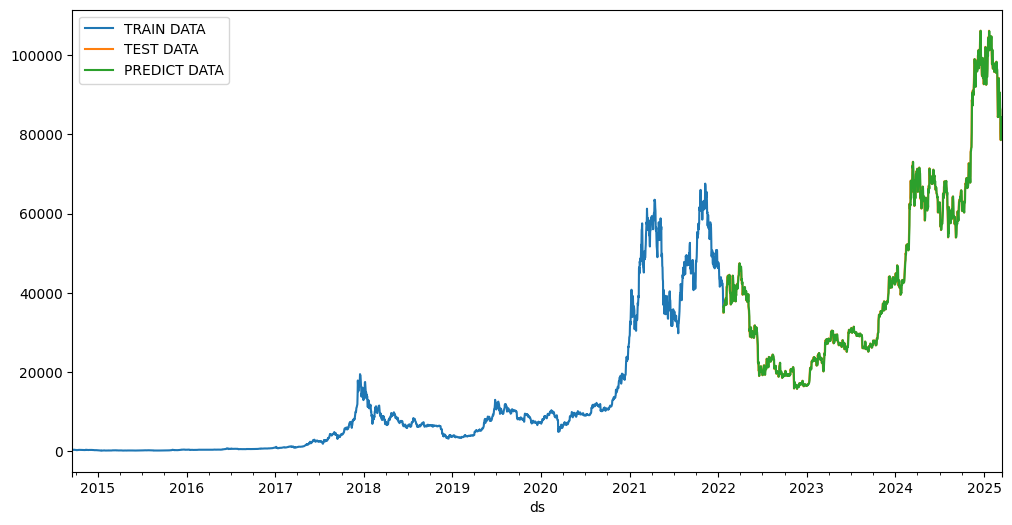

In [35]:
train['y'].plot(legend=True, label='TRAIN DATA')
test['y'].plot(legend=True, label='TEST DATA')
pd.DataFrame({'ds':test.index, 'y':predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICT DATA', figsize=(12, 6))


In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3834
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7268.301
Date:                Tue, 25 Mar 2025   AIC                         -14532.601
Time:                        21:34:19   BIC                         -14520.098
Sample:                             0   HQIC                        -14528.159
                               - 3834                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0198      0.010     -1.984      0.047      -0.039      -0.000
sigma2         0.0013   1.18e-05    112.063      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             21144.61
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""